In [1]:
import sys
import os

# Add the workspace directory to the system path
sys.path.append(os.path.abspath('..'))

# Now you should be able to import the class
from model import preprocess_data
from model.train import HST

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2024-07-17 12:10:39.274269: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-17 12:10:39.647407: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-17 12:10:39.649658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 12:10:40.881436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_dataset, test_dataset = preprocess_data.load_data(data_path="/home/pbr-student/personal/thesis/test/PedestrianTrajectoryPrediction/df_jrdb.pkl", batch_size=32)

2024-07-17 12:10:55.466266: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-07-17 12:11:25.467559: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-07-17 12:11:55.474491: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-07-17 12:12:25.481915: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-07-17 12:12:55.487139: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the

In [16]:
import datetime
import tensorflow as tf

model_base_dir = ""
dt_str = datetime.datetime.now().strftime('2024-07-15_15:57:20')
model_dir = os.path.join(model_base_dir, dt_str)
ckpt_dir = "/home/pbr-student/personal/thesis/test/PedestrianTrajectoryPrediction/2024-07-15_15:57:20/ckpts/last"
ckpt_best_dir = "/home/pbr-student/personal/thesis/test/PedestrianTrajectoryPrediction/2024-07-15_15:57:20/ckpts_best/ckpt"

def test_model(checkpoint_dir, test_dataset):
    
    model = HST(15)  # Initialize the model architecture
    optimizer = tf.keras.optimizers.Adam()
    
    # Create a checkpoint object
    checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
    
    # Restore the latest checkpoint
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        checkpoint.restore(latest_checkpoint)
        print(f"Restored checkpoint from {latest_checkpoint}")
    else:
        print("No checkpoint found.")
        return
    
    # Run a forward pass with a batch from the test dataset
    for (batch_x1, batch_x2) in test_dataset.take(1):
        input_batch = (batch_x1, batch_x2)
        output = model(input_batch, training=False)
        print(output)
        break
    return input_batch, output


In [17]:
input, pred = test_model(ckpt_dir, test_dataset)

Restored checkpoint from /home/pbr-student/personal/thesis/test/PedestrianTrajectoryPrediction/2024-07-15_15:57:20/ckpts/last/ckpt-22
{'mask': array([[ True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False],
       [ True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False],
       [False, False,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False],
       [False,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False],
       [ True,  True,  True, False, False,  True, False, False, False,
        False, False, False, False, False, False],
       [ True, False,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False],
       [False,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False],
   

In [13]:
for (batch_x1, batch_x2) in test_dataset.take(1):
    input_pos = batch_x1[0]
    print(input_pos)

tf.Tensor(
[[ 0.435   -1.525    0.09826]
 [ 0.44    -1.53     0.09826]
 [ 0.45411 -1.5072   0.09826]
 [ 0.46822 -1.4844   0.09826]
 [ 0.48698 -1.43988  0.09826]
 [ 0.50575 -1.39535  0.09826]
 [ 0.52287 -1.34268  0.09826]
 [ 0.54    -1.29     0.09826]
 [ 0.55052 -1.23986  0.09826]
 [ 0.56104 -1.18972  0.09826]
 [ 0.56543 -1.14104  0.09826]
 [ 0.56982 -1.09236  0.09826]
 [ 0.56991 -1.04118  0.09826]
 [ 0.57    -0.99     0.09826]
 [ 0.56954 -0.93366  0.09826]], shape=(15, 3), dtype=float64)


In [85]:
print(pred["position"][2,:,0,:])

tf.Tensor(
[[ 0.67060417 -1.0735161   0.3789265 ]
 [ 0.67060417 -1.0735161   0.3789265 ]
 [ 0.62727314 -0.88621724  0.42070338]
 [ 0.62727314 -0.88621724  0.42070338]
 [ 0.62727314 -0.88621724  0.42070338]
 [ 0.62727314 -0.88621724  0.42070338]
 [ 0.67060417 -1.0735161   0.3789265 ]
 [ 0.67060417 -1.0735161   0.3789265 ]
 [ 0.67060417 -1.0735161   0.3789265 ]
 [ 0.67060417 -1.0735161   0.3789265 ]
 [ 0.67060417 -1.0735161   0.3789265 ]
 [ 0.67060417 -1.0735161   0.3789265 ]
 [ 0.6706039  -1.0735157   0.37892666]
 [ 0.6706039  -1.0735157   0.37892666]
 [ 0.6706039  -1.0735157   0.37892666]], shape=(15, 3), dtype=float32)


In [86]:
import matplotlib.pyplot as plt 
import numpy as np 

idx = 6
mode = 0

ground_truth = input[0][idx][:,:2].numpy()
prediction = pred["position"][idx,:,mode,:2].numpy()

In [36]:
%matplotlib inline

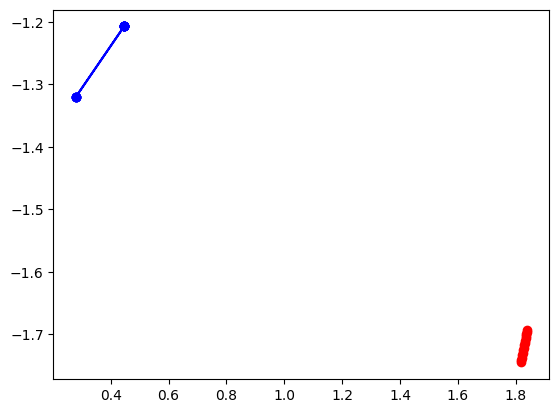

In [87]:
plt.plot(ground_truth[:,0], ground_truth[:,1], 'ro-')
plt.plot(prediction[:,0], prediction[:,1],'bo-')
plt.show()
